# B1 - THE CNN MODEL
### This notebook trains a CNN using the train image data. It uses train test split to create a Train and Validation data with we use to tune the model.

### Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image

from sklearn.model_selection import  train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical



import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model

In [2]:
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


Num GPUs Available:  0


### Utility Functions

In [5]:
# show class meta. takes class label as a number (0 to 43) and plts the meta image for the specific class
# using
def show_class_meta(class_num):
    plt.figure(figsize=(2,2))
    path = "../data/final_sign_images/Meta/" #Not able to push data to git, give local file path
    # no alternate path in git dir just dont run
    link_to_image = str(path + str(class_num) + '.png')
    class_img = imread(link_to_image)
    plt.imshow(class_img)
    plt.xlabel(class_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(class_img.shape[0], fontsize = 10)#height of image
    plt.title("Class: " + str(class_num))
    

In [6]:
# Data sets summary
# not really needed
def info_dataset(X_train, X_valid, y_train):
    # Number of training examples
    n_train = X_train.shape[0]

    # Number of validation examples
    n_validation = X_valid.shape[0]

    # Shape of an traffic sign image
    image_shape = X_train[0].shape

    # Unique classes/labels in the dataset.
    n_classes = max(y_train)+1

    print("Number of training examples =", n_train)
    print("Number of validation examples =", n_validation)
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes)

In [7]:
# Convert images to grayscale
# might delete
def RGB2GREY(data_RGB):
    
    n_data=data_RGB.shape[0]
    data_gr=np.zeros((n_data,32,32,1))
    for i in range(n_data):
        tmp = cv2.cvtColor(data_RGB[i], cv2.COLOR_RGB2GRAY)
        data_gr[i]= np.reshape(tmp,(32,32,1))
    
    return data_gr

In [8]:
# Generate more image examples to balance the dataset
# really useful
def expand_dataset(data_gr,data_labels):
    
    n_data=data_gr.shape[0]
    
    p_insts=np.zeros(n_classes)
    for i in range(n_classes):
        sum_ints = np.sum(data_labels==i)
        p_insts[i] = sum_ints/n_data
    
    n_aug=int(1.0*n_data)
    aug_X=np.array(np.zeros((n_aug,32,32,1)))
    aug_y=np.array(np.zeros((n_aug)))
    for i in range(n_aug):
        index = random.randint(0, n_data-1)
        aug_X[i]=data_gr[index]
        aug_y[i]=data_labels[index]
        p_trigg = random.uniform(1/np.max(p_insts),1/np.min(p_insts))
        while p_insts[int(aug_y[i])]*p_trigg>1.05: # Generate more data for those classes with less representation
            index = random.randint(0, n_data-1)
            aug_X[i]=data_gr[index]
            aug_y[i]=data_labels[index]
            sum_ints=np.sum(data_labels==aug_y[i])
            p_trigg = random.uniform(1/np.max(p_insts),1/np.min(p_insts))

    for i in range(n_aug):
        n = random.randint(2,4)
        rot = random.randint(-20, 20)
        M = cv2.getRotationMatrix2D((32/n,32/n),rot,1)
        tmp = cv2.warpAffine(aug_X[i],M,(32,32))
        
        noise = 10*np.random.random((32, 32))
        tmp = tmp+noise
        aug_X[i] = np.reshape(tmp,(32,32,1))
    
    return aug_X, aug_y

In [9]:
#Normalisation of data if need 
def norm_data(data_gr):
    
    return (data_gr-128)/128

### Helper Functions for Training the CNN

In [10]:
class MetricsCheckpoint(Callback):
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
        
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            np.save(self.savepath, self.history)
        
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['accuracy'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
     
def plot_learning_curve(history):
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('./loss_curve.png')

###  1. Quick Explore : Plotting 12 images to check dataset

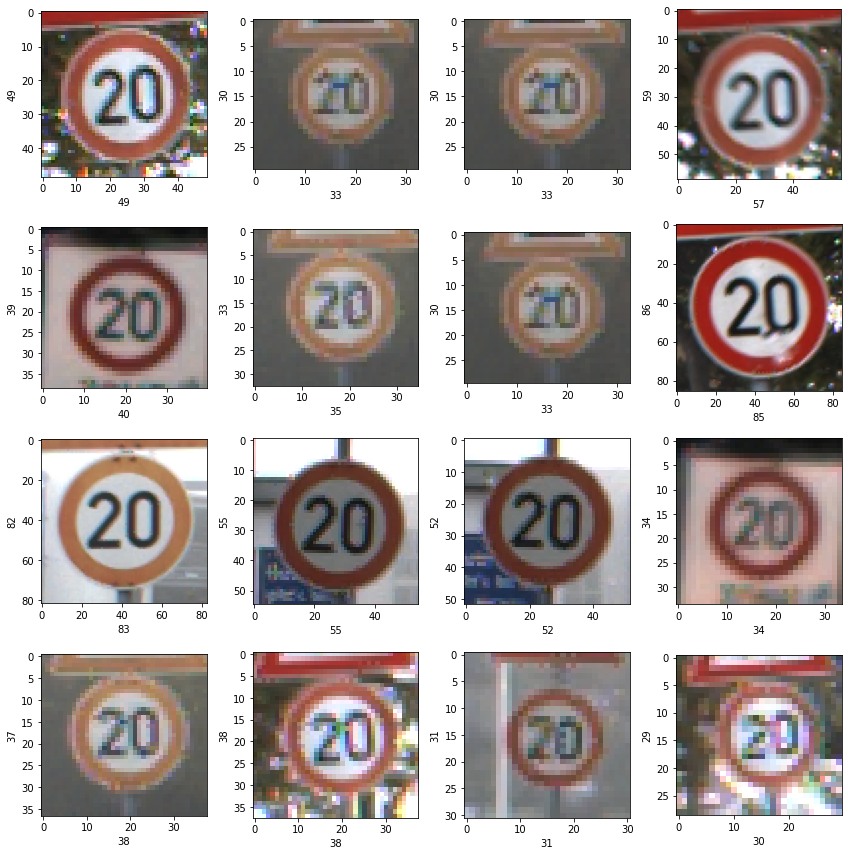

In [11]:
# just a quick explore to see the images
plt.figure(figsize=(12,12))
path = "../data/final_sign_images/Train/0" #Not able to push data to git, give local file path
#path = "./data/German_final_dataset/Train/0"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

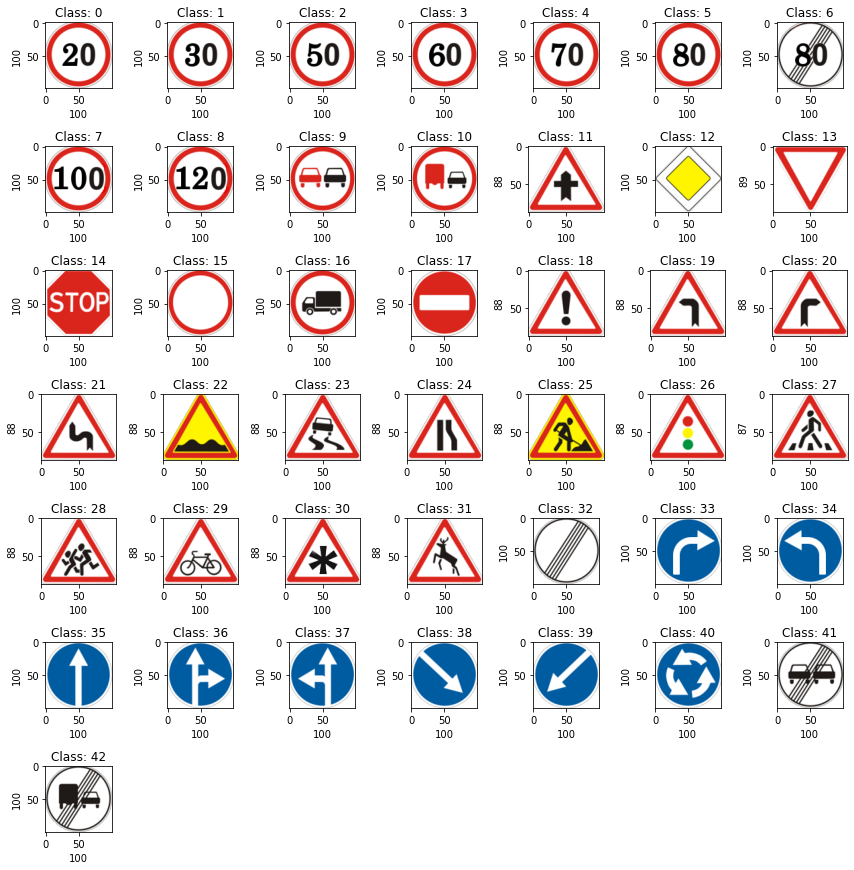

In [12]:
# meta data images for each class
plt.figure(figsize=(12,12))
path = "../data/final_sign_images/Meta/" #Not able to push data to git, give local file path
# no alternate path in git dir just dont run
for i in range(0,43):
    plt.subplot(7,7,i+1)
    plt.tight_layout()
    link_to_image = str(path + str(i) + '.png')
    class_img = imread(link_to_image)
    plt.imshow(class_img)
    plt.xlabel(class_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(class_img.shape[0], fontsize = 10)#height of image
    plt.title("Class: " + str(i))

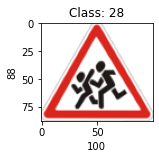

In [15]:
# show th meta class image
show_class_meta(28)

### 2. Image Preprocessing
- Find the mean dimension ans rezize all images to this size

In [16]:
# Finding mean of dimensions
dim1 = []
dim2 = []
images = []
label_id = []

for i in range(0,43):
    labels = '../data/final_sign_images/Train/'+ str(i)#Not able to push data to git, give local file path
    image_path = os.listdir(labels)
    for x in image_path:
        img = imread(labels + '/' + x)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])
        img = np.array(img)
        images.append(img)
        label_id.append(i)

In [17]:
#Printing mean dimension of images
print("Dimension 1 Mean : ",np.mean(dim1), " Dimension 2 Mean : ",np.mean(dim2))

Dimension 1 Mean :  50.328929582493814  Dimension 2 Mean :  50.83587951745773


In [18]:
#Resize all the images to mean of (50,50)
data = []
images = []
labels = []

for i in range(0,43):
    path = '../data/final_sign_images/Train/'+ str(i)#Not able to push data to git, give local file path
    #path = './data/German_final_dataset/Train/'+ str(i)
    image_path = os.listdir(path)
    for a in image_path:
        link_to_image = str(path + '/'+ a)
        img = Image.open(link_to_image)
        img = img.resize((50,50))
        img = np.array(img)
        data.append(img)
        labels.append(i)
data = np.array(data)
labels = np.array(labels)       

In [19]:
data.shape

(39209, 50, 50, 3)

In [20]:
labels.shape

(39209,)

In [21]:
label_counts = pd.DataFrame(labels).value_counts()
label_counts.head

<bound method NDFrame.head of 2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
8     1410
3     1410
11    1320
35    1200
18    1200
17    1110
31     780
14     780
33     689
15     630
26     600
28     540
23     510
30     450
34     420
16     420
6      420
22     390
36     390
20     360
40     360
21     330
39     300
29     270
24     270
42     240
41     240
27     240
32     240
19     210
37     210
0      210
dtype: int64>

In [22]:
percent_per_class = label_counts/data.shape[0]*100
percent_per_class.sort_index()

0     0.535591
1     5.661965
2     5.738478
3     3.596113
4     5.049861
5     4.743809
6     1.071183
7     3.672626
8     3.596113
9     3.749139
10    5.126374
11    3.366574
12    5.355913
13    5.508939
14    1.989339
15    1.606774
16    1.071183
17    2.830983
18    3.060522
19    0.535591
20    0.918157
21    0.841644
22    0.994670
23    1.300722
24    0.688617
25    3.825652
26    1.530261
27    0.612104
28    1.377235
29    0.688617
30    1.147696
31    1.989339
32    0.612104
33    1.757250
34    1.071183
35    3.060522
36    0.994670
37    0.535591
38    5.279400
39    0.765130
40    0.918157
41    0.612104
42    0.612104
dtype: float64

Note: The percentage representation of each of the 43 classes is not perfectly balanced it ranges from 0.5% (210images) to about 5.7%(2220 images) of the whole dataset.

### 3. Train Validation Split  (70-30)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(data, labels , test_size = 0.3, random_state = 42)

In [24]:
print(X_train.shape, X_val.shape, y_train.shape,y_val.shape)

(27446, 50, 50, 3) (11763, 50, 50, 3) (27446,) (11763,)


In [25]:
# set to categorical
y_train = to_categorical(y_train,43)
y_val = to_categorical(y_val,43)

In [26]:
X_train.shape[1:]

(50, 50, 3)

### 4. Model Setup

In [33]:
# model switches and parameters

# options currently 'A','B', 'VGG16' ?? if i can
model_switch = 'B'

# options to try 10, 15, 20
my_epochs = 20

# options to try  = 'adam','sgd','RMS','ada_delta','ada_max'
my_optimizer = 'adam'

my_metrics = ['accuracy']

# options to try = 32,64,128
my_batch_size = 32

# options = True or False
my_shuffle = True

In [28]:
if (model_switch =='B'):
    print('This model is choosen')
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation='softmax'))

This model is choosen


In [29]:
# model A
if (model_switch =='A'):
    print('This model is choosen')
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = X_train.shape[1:], activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation = 'softmax'))

In [30]:
# model C
if (model_switch =='C'):
    print('This model is choosen')
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = X_train.shape[1:], activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation = 'softmax'))

In [34]:
# Compile model and print its summary
# This is the Model Architecture
model.compile(loss='categorical_crossentropy', optimizer=my_optimizer, metrics=my_metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

### 5. Run the Model 
#### Checkpoint and Early Stopping Setup

In [35]:
# Setting up early stopping and ModelCheckpoint
# This will help me choose a model that is best without over fitting 

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#where each of the imtermediate models are stored 
model_file = './model_store/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'

#maximizing val_accuracy, store only the best models  
checkpoint = ModelCheckpoint(model_file, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

#If after 3 epochs the val_accuracy does not improve just stop 
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1, mode='auto')

In [36]:
history = model.fit(X_train, y_train, epochs = my_epochs , batch_size = my_batch_size, validation_data = (X_val, y_val), verbose = 2,shuffle = my_shuffle,callbacks = [checkpoint,early])
print(history)

Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.94126, saving model to ./model_store/weights.01-0.94.hdf5
858/858 - 80s - loss: 1.3999 - accuracy: 0.6516 - val_loss: 0.2086 - val_accuracy: 0.9413
Epoch 2/20

Epoch 00002: val_accuracy improved from 0.94126 to 0.96872, saving model to ./model_store/weights.02-0.97.hdf5
858/858 - 80s - loss: 0.3953 - accuracy: 0.8834 - val_loss: 0.1158 - val_accuracy: 0.9687
Epoch 3/20

Epoch 00003: val_accuracy improved from 0.96872 to 0.97654, saving model to ./model_store/weights.03-0.98.hdf5
858/858 - 80s - loss: 0.2597 - accuracy: 0.9240 - val_loss: 0.0960 - val_accuracy: 0.9765
Epoch 4/20

Epoch 00004: val_accuracy improved from 0.97654 to 0.98181, saving model to ./model_store/weights.04-0.98.hdf5
858/858 - 80s - loss: 0.2370 - accuracy: 0.9310 - val_loss: 0.0723 - val_accuracy: 0.9818
Epoch 5/20

Epoch 00005: val_accuracy improved from 0.98181 to 0.98240, saving model to ./model_store/weights.05-0.98.hdf5
858/858 - 81s - loss: 0.1883

### 6. Model Validation

In [37]:
from sklearn.metrics import confusion_matrix
class_label = list(range(0,43))

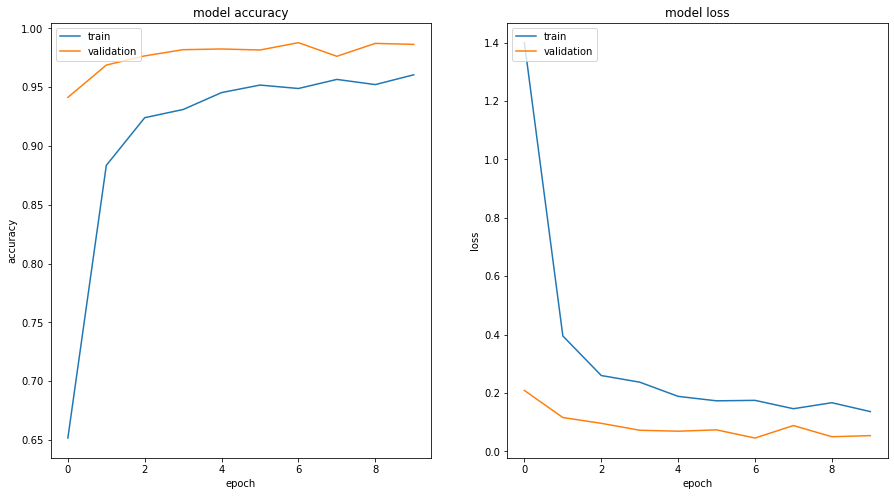

In [38]:
y_pred = model.predict(X_val)

# reconverts back from one hot encoded
y_pred_classes = np.argmax(y_pred,axis = 1)   

# reconverts back from one hot encoded
y_true = np.argmax(y_val,axis = 1)  

# plot the learning curves
plot_learning_curve(history)

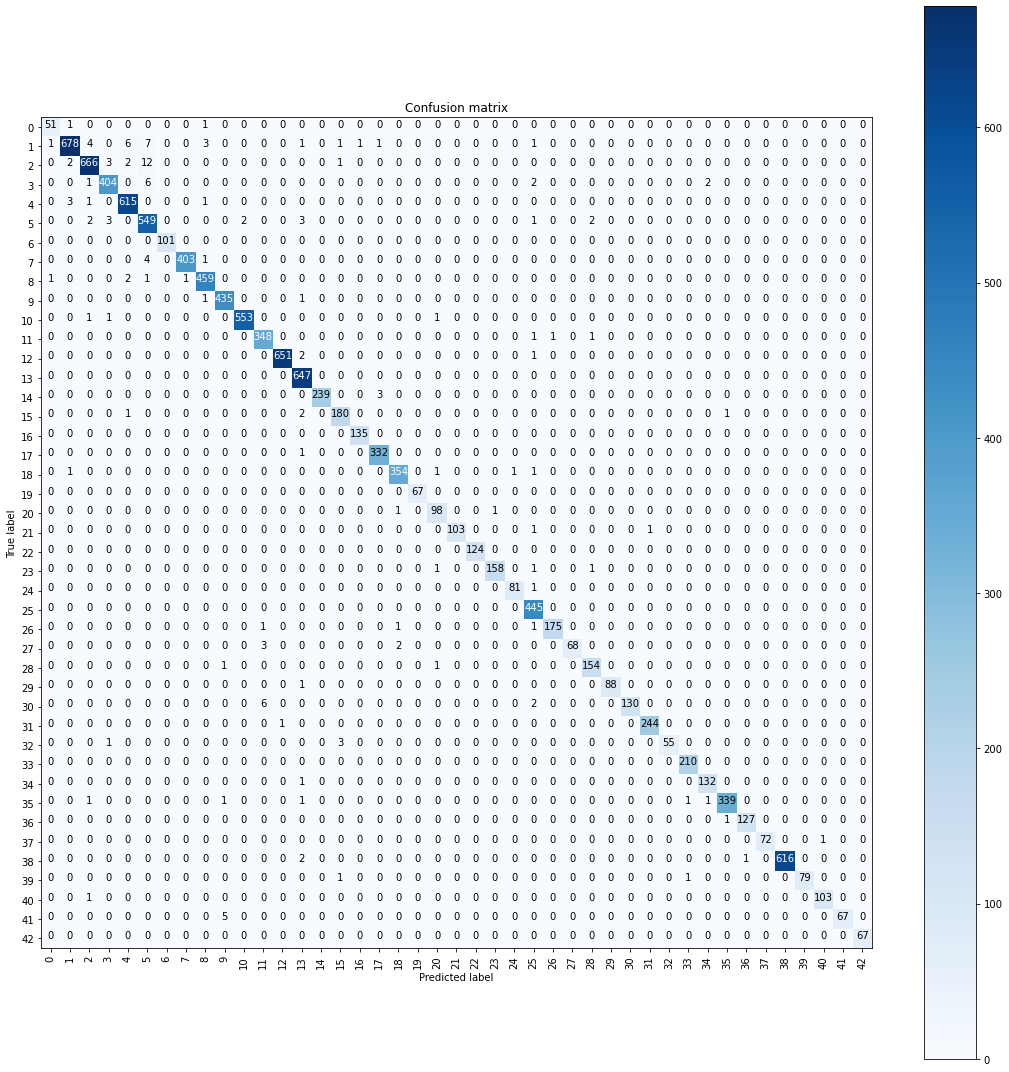

In [39]:
confusion_mtx = confusion_matrix(y_true,y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = class_label)

In [40]:
for key in history.history:
    print(key)

loss
accuracy
val_loss
val_accuracy


In [41]:
evaluation = pd.DataFrame(history.history)
evaluation

,loss,accuracy,val_loss,val_accuracy
0,1.399914,0.651643,0.208588,0.941256
1,0.395324,0.883444,0.115804,0.968715
2,0.259700,0.923996,0.095976,0.976537
3,0.237004,0.930955,0.072287,0.981807
4,0.188322,0.945347,0.068975,0.982402
5,0.173042,0.951723,0.073538,0.981552
6,0.174662,0.948809,0.045592,0.987758
7,0.146006,0.956533,0.088313,0.976197
8,0.166588,0.952124,0.050102,0.987163
9,0.136194,0.960468,0.053802,0.986313


In [43]:
# Classification Report

In [44]:
from sklearn.metrics import classification_report

In [45]:
class_string = []
for i in range (0,43):
    label = 'Class: ' + str(i)
    class_string.append(label)

In [46]:
print(classification_report(y_true,y_pred_classes, target_names=class_string))

              precision    recall  f1-score   support

    Class: 0       0.96      0.96      0.96        53
    Class: 1       0.99      0.96      0.98       704
    Class: 2       0.98      0.97      0.98       686
    Class: 3       0.98      0.97      0.98       415
    Class: 4       0.98      0.99      0.99       620
    Class: 5       0.95      0.98      0.96       562
    Class: 6       1.00      1.00      1.00       101
    Class: 7       1.00      0.99      0.99       408
    Class: 8       0.98      0.99      0.99       464
    Class: 9       0.98      1.00      0.99       437
   Class: 10       1.00      0.99      1.00       556
   Class: 11       0.97      0.99      0.98       351
   Class: 12       1.00      1.00      1.00       654
   Class: 13       0.98      1.00      0.99       647
   Class: 14       1.00      0.99      0.99       242
   Class: 15       0.97      0.98      0.97       184
   Class: 16       0.99      1.00      1.00       135
   Class: 17       0.99    

### 7. Choose and store the best model  
Reasoning:
The model stopped after the 9th epoch when there was no significant improvement in val_accurracy. 
The curves for validation and training have not met. accuracy is 96% vs val_acc which is 98% it is therefore unlikely that any overfitting has occurred. We are writing the the model as the final_model 

In [47]:
# Save the final model
model.save('./model_store/final_model.h5')

## NEXT NOTEBOOK : B2  ----  CNN-Test.ipynb
#### Here we will use the final_model.h5 to make predictions on the unseen Test data from the dataset